# Assignment 2


## Preliminary Steps

Importing Libraries

In [1]:
# Handle files and unzip
import os
import requests
import zipfile

import re

import pandas as pd
import numpy as np

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Word tokenization
from tensorflow.keras.preprocessing.text import Tokenizer


import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
!pip install tqdm
from tqdm import tqdm as tq 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf
from keras.layers import * 
from keras.initializers import Constant
from keras.models import *

import random
from copy import copy 
import urllib

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Downloading the dataset

In [2]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


Look inside our dataset creating a first dataframe reading the `test_pairs.csv` file

In [3]:
train_path = os.path.join(os.getcwd(), 'dataset', 'train_pairs.csv')
val_path = os.path.join(os.getcwd(), 'dataset', 'val_pairs.csv')
test_path = os.path.join(os.getcwd(), 'dataset', 'test_pairs.csv')

## Data preparation

As stated in [specifications.ipynb](specifications.ipynb), each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)



Now is time to clean up our data a little bit and construct our dataframe. We created two methods:

1.   `sentence_cleaning` to clean the dataset from  "-LRB-", "-RRB-", "-LSB-" and "-RSB-".
2.   `format_dataset` that read the csv file and create a dataset with 'Claim' 'Evidence' and 'Label' labels.

In [4]:
dataset_path = os.path.join(os.getcwd(), 'dataset', 'train_pairs.csv')

def sentence_cleaning(sentence: str) -> str:
    """
    cleans up a sentence in the dataset using regular expressions
    :param sentence: the sentence to clean-up
    :return
        - string cleaned
    """
    
    # removes "-LRB-" and "-RRB-" "-LSB-" and "-RSB-" strings 
    sentence = re.sub("-LRB-","", sentence)
    sentence = re.sub("-RRB-", "", sentence)
    #sentence = re.sub(",", "", sentence) #TODO ?
    sentence = re.sub("-LSB-", "", sentence)
    sentence = re.sub("-RSB-", "", sentence)
    
    return sentence

In [5]:
def format_dataset(dataset: str, debug: bool = True) -> pd.DataFrame:
    """
    Reads out the csv file and returns a dataframe with 
    {Claim, Evidence, Label} row
    
    :param dataset: dataset csv file path
    :param debug: if True prints out data for debugging purposes
    
    :return
        - dataframe with (claim, evidence, label) rows
    """
    
    df = pd.read_csv(dataset)
    dataframe_rows = []
    df_size = df.shape[0]

    for i in range(0, df_size):

        claim = df["Claim"][i]
        claim = sentence_cleaning(str(claim))

        label = df["Label"][i]

        ev_list = df["Evidence"][i].split('\t')
        evidence = sentence_cleaning(str(ev_list[1]))
        #evidence = ev_list[1] #TODO ?

        # create single dataframe row
        dataframe_row = {
            "Claim": claim,
            "Evidence": evidence,
            "Label": label
        }

        if debug: 
            print(claim)
            print(evidence)
            print(label)

        dataframe_rows.append(dataframe_row)

    df = pd.DataFrame(dataframe_rows)
    
    return df, dataframe_rows

In [6]:
df, df_rows = format_dataset(dataset_path, False)

df['Claim_Evidence'] = df.Claim + df.Evidence
df['Label'] = df.Label

df_train, df_rows_train = format_dataset(train_path, False)
df_val, df_rows_val = format_dataset(val_path, False)
df_test, df_rows_test = format_dataset(test_path, False)


df_tot = pd.concat([df_train, df_val, df_test])
df_tot = df_tot.reset_index()
df_tot['Claim_Evidence'] = df_tot.Claim + df_tot.Evidence

We plotted the quantities of support labels and refutes labels for our datasets. Let's see how our **training set** looks like:

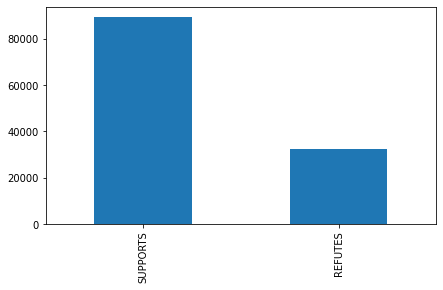

In [7]:
#Plotting the quantity of the classes on the training set
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

df_train["Label"].value_counts().plot.bar()

We can see that the training set is unbalanced

Now, it's the turn of our **validation set**

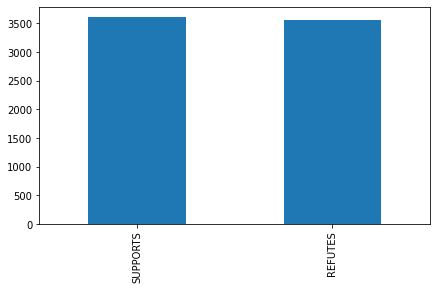

In [8]:
#Plotting the quantity of the classes on the validation set
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

df_val["Label"].value_counts().plot.bar()

Last but not least, our **test set**

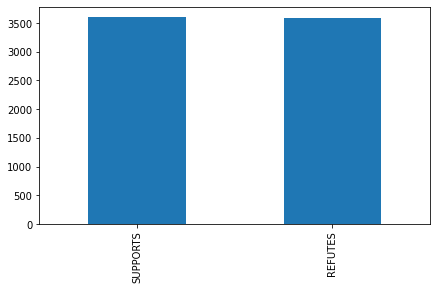

In [9]:
#Plotting the quantity of the classes on the test set
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

df_test["Label"].value_counts().plot.bar()

Let's show the first 5 rows of the resulting dataframe

In [11]:
df.head()

,Claim,Evidence,Label,Claim_Evidence
0,Chris Hemsworth appeared in A Perfect Getaway.,Hemsworth has also appeared in the science fic...,SUPPORTS,Chris Hemsworth appeared in A Perfect Getaway....
1,Roald Dahl is a writer.,"Roald Dahl langpronˈroʊ.əld _ ˈdɑːl , ˈɾuː...",SUPPORTS,Roald Dahl is a writer.Roald Dahl langpronˈr...
2,Roald Dahl is a governor.,"Roald Dahl langpronˈroʊ.əld _ ˈdɑːl , ˈɾuː...",REFUTES,Roald Dahl is a governor.Roald Dahl langpron...
3,Ireland has relatively low-lying mountains.,The island 's geography comprises relatively l...,SUPPORTS,Ireland has relatively low-lying mountains.The...
4,Ireland does not have relatively low-lying mou...,The island 's geography comprises relatively l...,REFUTES,Ireland does not have relatively low-lying mou...


## Tokenization

Turning claims and evidences into sequences of integers using the Keras `Tokenizer`. The text we fit the Tokenizer on is the set of all values from the `Claim_Evidence` column.

In [12]:
lower=True 
filters='!"#$%&()*+-/:;<=>?@[\\]^_.`{|}~\t\n'

# Create the tokenizer object and train on texts
tokenizer = Tokenizer(lower=lower, filters=filters)
tokenizer.fit_on_texts(df_tot[0:len(df_rows_train)].Claim_Evidence)

# Create look-up dictionaries and reverse look-ups
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word
num_words = len(word_idx) + 1
word_counts = tokenizer.word_counts

# Convert text to sequences of integers
token_claim = tokenizer.texts_to_sequences(df_tot.Claim)
token_evidence = tokenizer.texts_to_sequences(df_tot.Evidence)

Now is time to construct the input matrices for the embedding step. We build those matrices starting from `token_claim` and `token_evidence`. The number of rows of the matrices is the number of elements in `token_claim` and `token_evidence`, while the number of columns is the size of the longest sequences. The rows corresponding to shorter sequences are filled with zero-padding.

In [13]:
# computes the longest token sequence
def longest_seq(seq):
    seq_len = [len(i) for i in seq]
    print(max(seq_len))
    return max(seq_len)

In [14]:
def matrix_from_sequences(sequences):
    """
    Builds a matrix of shape [batch_size, max_tokens]
    """
    
    max_tokens = longest_seq(sequences)
    seq_length = len(sequences)
    
    matrix = np.zeros((len(sequences), max_tokens), dtype=np.int32)
    
    for i in range(0, seq_length):
        for j in range(0, len(sequences[i])):
            matrix[i][j] = sequences[i][j]
    
    return matrix

In [15]:
claim_matrix = matrix_from_sequences(token_claim)
evidence_matrix = matrix_from_sequences(token_evidence)

76
137


### Dataframe split

Now we create matrices for Claims and Evidences starting from the other dataframes of training and validation sets. Then, we group all the training, validation and test data together.

In [16]:
claim_matrix_train = claim_matrix[0:len(df_rows_train)]
evidence_matrix_train = evidence_matrix[0:len(df_rows_train)]

claim_matrix_val = claim_matrix[len(df_rows_train): len(df_rows_train) +len(df_rows_val)]
evidence_matrix_val = evidence_matrix[len(df_rows_train): len(df_rows_train) +len(df_rows_val)]

claim_matrix_test = claim_matrix[len(df_rows_train) +len(df_rows_val)::]
evidence_matrix_test = evidence_matrix[len(df_rows_train) +len(df_rows_val)::]

data_train = (claim_matrix_train,evidence_matrix_train)
data_val = (claim_matrix_val,evidence_matrix_val)
data_test = (claim_matrix_test,evidence_matrix_test)

## Word Embedding
Now, we have to first create embedding for single words. For this purpose, we rely on the pre-trained **GloVe** embeddings. So we proceed downloading them.

We start downloading GloVe

In [17]:
url = "https://nlp.stanford.edu/data/glove.6B.zip"

glove_path = os.path.join(os.getcwd(),"Glove")
glove_zip = os.path.join(os.getcwd(),"Glove", "glove.6B.zip")

if not os.path.exists(glove_path):
    os.makedirs(glove_path)

if not os.path.exists(glove_zip):
    urllib.request.urlretrieve(url, glove_zip)
    print("Successful download")

with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall(path=glove_path)
    print("Successful extraction")


Successful download
Successful extraction


Creating GloVe dictionary

In [18]:
EMBEDDING_SIZE  = 50  # dimensions of the features of GloVe 
VOCABULARY_SIZE_TRAIN = num_words
embedding_weights = np.zeros((num_words, EMBEDDING_SIZE))

V1 = {}
glove_path = '/content/Glove'
with open(glove_path + '/glove.6B.{}d.txt'.format(EMBEDDING_SIZE),'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        V1[word]=vector
        
print("Found %s word vectors." % len(V1))

Found 400000 word vectors.


we created compute_embedding method to create the embeddings

In [19]:
def compute_embedding(word2id, vocabulary,embedding_weights):
  for word, index in tq(word2id.items()):
    if word in vocabulary:
      try: 
        embedding_weights[index, :] = V1[word] 
      except KeyError:
          embedding_weights[index, :] = np.random.uniform(random.choice(list(V1.values())))
          pass
  return embedding_weights

In [20]:
embedding_words = compute_embedding(word_idx,list(word_idx.keys()),embedding_weights)

100%|██████████| 37318/37318 [01:16<00:00, 486.88it/s]


### Sentence Embedding

Now it's time to actually compute **sentence embeddings**. After the computing sentence embeddings for Claim and Evidences, we must merge them, and we can choose between different strategies. Now we will try out the different approaches proposed in the specifications for computing our sentence embeddings. In particular we will implement 6 different approaches, which differs by technique used to compute embeddings and/or the technique used to merge embeddings. 

Those will be the merging strategies used:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

As a preliminary procedure, we defined a method to_cat that we used to encode the label column in order to make it computable by the models.

In [21]:
def to_cat(y, tokenizer):
  tokenizer.fit_on_texts(y)
  y = tokenizer.texts_to_sequences(y)
  y = tf.keras.utils.to_categorical( y, num_classes=None, dtype='int')
  return y

In [22]:
y_train = df_train.Label
tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(y_train)
y_train = to_cat(y_train, tokenizer_y)

y_val = to_cat(df_val.Label, tokenizer_y)

y_test = to_cat(df_test.Label, tokenizer_y)

### 1. Encode token sequences via a RNN and take the last state as the sentence embedding.

We created the method model_creation() that encodes token sequences via a RNN taking the **last state as the sentence embedding**.

In [23]:
def model_creation_last():  
  sequence_length_cl = claim_matrix.shape[1]
  sequence_length_ev = evidence_matrix.shape[1]
  embed_dim = 50 # dimensions of Vectors's GloVe
  embedding_matrix= embedding_words #np.random.rand(claim_matrix.shape[0],embed_dim)

  claim_input = Input(shape=(sequence_length_cl,), name = 'claim_input')
  embedding_layer_c = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix], 
                              input_length = sequence_length_cl, trainable=True, 
                              name='claim_embedding')

  evidence_input = Input(shape=(sequence_length_ev,), name = 'evidence_input')
  embedding_layer_e = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix], 
                              input_length = sequence_length_ev, trainable=True, 
                              name='evidence_embedding')

  embedded_claim = embedding_layer_c(claim_input)
  embedded_evidence = embedding_layer_e(evidence_input)

  X_claim = Bidirectional(LSTM(units=int(embed_dim/2), 
                          name='Bidirectional_Claim', 
                          #dropout=0.25,  #TODO ?
                          #recurrent_dropout=0.25, 
                          return_sequences=False))(embedded_claim) 
                      # If you want to switch merge_mode='concat', for the 1 point
                      # purpose we check it as None #TODO ?


  X_evidence = Bidirectional(LSTM(units=int(embed_dim/2), 
                          name='Bidirectional_Evidence',
                          return_sequences=False 
                            ))(embedded_evidence) 
                      # If you want to switch merge_mode='concat', for the 1 point
                      # purpose we check it as None
  return X_claim, X_evidence, claim_input, evidence_input


## 2. Encode token sequences via a RNN and average all the output states.

We will compute emeddings with the method model_creation_ave() by encoding token sequences via a RNN and **average all the output states**.

In [24]:
def  model_creation_ave():
  sequence_length_cl = claim_matrix.shape[1]
  sequence_length_ev = evidence_matrix.shape[1]
  embed_dim = 50 # for glove50.txt
  embedding_matrix= embedding_words #np.random.rand(claim_matrix.shape[0],embed_dim) #TODO ?

  claim_input = Input(shape=(sequence_length_cl,), name = 'claim_input')
  embedding_layer_c = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix], 
                              input_length = sequence_length_cl, trainable=True, 
                              name='claim_embedding')

  evidence_input = Input(shape=(sequence_length_ev,), name = 'evidence_input')
  embedding_layer_e = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix], 
                              input_length = sequence_length_ev, trainable=True, 
                              name='evidence_embedding')

  embedded_claim = embedding_layer_c(claim_input)
  embedded_evidence = embedding_layer_e(evidence_input)

  X_claim = Bidirectional(LSTM(units=int(embed_dim/2), 
                          name='Bidirectional_Claim', 
                          #dropout=0.25,  
                          #recurrent_dropout=0.25, 
                          return_sequences=True))(embedded_claim) 
                      # If you want to switch merge_mode='concat', for the 1 point
                      # purpose we check it as None



  X_evidence = Bidirectional(LSTM(units=int(embed_dim/2), 
                          name='Bidirectional_Evidence',
                          return_sequences=True 
                            ))(embedded_evidence) 
                      # If you want to switch merge_mode='concat', for the 1 point
                      # purpose we check it as None

  #
  X_evidence = tf.reduce_mean(X_evidence, 1, 
                          name='Mean_evidence')
  X_claim = tf.reduce_mean(X_claim, 1, 
                          name='Bidirectional_Evidence')

  return X_claim,X_evidence, claim_input, evidence_input


## 3. Encode token sequences via a simple MLP layer. 

In the method model_creation_NLP we compute the embedding encoding token sequences via a simple **MLP layer**. 

In [25]:
def model_creation_MLP():  
  sequence_length_cl = claim_matrix.shape[1] 
  sequence_length_ev = evidence_matrix.shape[1] 
  embed_dim = 50 # for glove50.txt 
  embedding_matrix= embedding_words #np.random.rand(claim_matrix.shape[0],embed_dim) 
  
  claim_input = Input(shape=(sequence_length_cl,), name = 'claim_input') 
  embedding_layer_c = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix],  
                              input_length = sequence_length_cl, trainable=True,  
                              name='claim_embedding') 
  
  evidence_input = Input(shape=(sequence_length_ev,), name = 'evidence_input') 
  embedding_layer_e = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix],  
                              input_length = sequence_length_ev, trainable=True,  
                              name='evidence_embedding') 
  
  embedded_claim = embedding_layer_c(claim_input) 
  embedded_evidence = embedding_layer_e(evidence_input) 
  
  X_claim = tf.reshape(embedded_claim, [-1, sequence_length_cl*embed_dim]) 
  X_evidence = tf.reshape(embedded_evidence, [-1, sequence_length_ev*embed_dim]) 
  
  
  X_claim = Dense(embed_dim,activation='relu')(X_claim)  
  X_evidence = Dense(embed_dim,activation='relu')(X_evidence)  
  
  return X_claim,X_evidence, claim_input, evidence_input

### 4. Compute the sentence embedding as the mean of its token embeddings (bag of vectors).

We compute the sentence embedding as the **mean of its token embeddings (Bag of Vectors)** with the methos model_creation_bov()



In [26]:
def model_creation_bov():  
  sequence_length_cl = claim_matrix.shape[1]
  sequence_length_ev = evidence_matrix.shape[1]
  embed_dim = 50 # for glove50.txt 
  embedding_matrix= embedding_words #np.random.rand(claim_matrix.shape[0],embed_dim) 
  
  claim_input = Input(shape=(sequence_length_cl,), name = 'claim_input') 
  embedding_layer_c = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix],  
                              input_length = sequence_length_cl, trainable=True,  
                              name='claim_embedding') 
  
  evidence_input = Input(shape=(sequence_length_ev,), name = 'evidence_input') 
  embedding_layer_e = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix],  
                              input_length = sequence_length_ev, trainable=True,  
                              name='evidence_embedding') 
  
  embedded_claim = embedding_layer_c(claim_input) 
  embedded_evidence = embedding_layer_e(evidence_input) 
  
  
  X_claim = tf.math.reduce_mean( 
      embedded_claim, axis=-1, keepdims=False, name=None 
  ) 
  
  X_evidence = tf.math.reduce_mean( 
      embedded_evidence, axis=-1, keepdims=False, name=None 
  ) 

  X_claim = Dense(embed_dim,activation='relu')(X_claim)  
  X_evidence = Dense(embed_dim,activation='relu')(X_evidence)  
 
  return X_claim,X_evidence, claim_input, evidence_input

We create the method `model_compile_fit` to compile and fit each model

In [38]:
def model_compile_fit(claim_input, evidence_input, model_input,epochs, batch_size):
  model = keras.Model([claim_input,evidence_input], model_input)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  history = model.fit(data_train, y_train,validation_data=(data_val,y_val),epochs= epochs, batch_size= batch_size, verbose=1)
  return model, history

## Model creation and fitting

We start to compute the sentence embedding, for merging we use **Concatenation**.

In [28]:
#1. Encode token sequences via a RNN and take the last state as the sentence embedding.
X_claim_last_c, X_evidence_last_c, claim_input_last_c, evidence_input_last_c = model_creation_last()
last_input_conc = concatenate([X_claim_last_c, X_evidence_last_c], name='last_input_conc',axis=1)
last_input_conc = (Dropout(0.25))(last_input_conc)
last_input_conc = (Dense(units=3, activation='sigmoid', use_bias=False))(last_input_conc)

In [39]:
model_last_conc, history_last_conc = model_compile_fit(claim_input_last_c, evidence_input_last_c, last_input_conc, 10, 1280)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                            

In [64]:
#2. Encode token sequences via a RNN and average all the output states. 
X_claim_ave_c, X_evidence_ave_c, claim_input_ave_c, evidence_input_ave_c = model_creation_ave()
ave_input_conc = concatenate([X_claim_ave_c, X_evidence_ave_c], name='ave_input_conc',axis=1)
ave_input_conc = (Dropout(0.25))(ave_input_conc)
ave_input_conc = (Dense(units=3, activation='sigmoid', use_bias=False))(ave_input_conc)

In [65]:
#Fitting the model 
model_ave_conc, history_ave_conc = model_compile_fit(claim_input_ave_c, evidence_input_ave_c, ave_input_conc, 10, 1280)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                            

In [134]:
#3. Encode token sequences via a simple MLP layer.
X_claim_mlp_c, X_evidence_mlp_c, claim_input_mlp_c, evidence_input_mlp_c = model_creation_MLP()
mlp_input_conc = concatenate([X_claim_mlp_c, X_evidence_mlp_c], name='mlp_input_conc',axis=1) 
mlp_input_conc = (Dropout(0.5))(mlp_input_conc) 
mlp_input_conc = (Dense(units=3, activation='sigmoid', use_bias=False))(mlp_input_conc)

In [136]:
#Fitting the model 
model_mlp_conc , history_mlp_conc= model_compile_fit(claim_input_mlp_c, evidence_input_mlp_c, mlp_input_conc, 10, 1280)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                           

In [137]:
#4. Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
X_claim_bov_c, X_evidence_bov_c, claim_input_bov_c, evidence_input_bov_c = model_creation_bov()
bov_input_conc = concatenate([X_claim_bov_c, X_evidence_bov_c], name='bov_input_conc',axis=1) 
bov_input_conc = (Dropout(0.5))(bov_input_conc) 
bov_input_conc = (Dense(units=3, activation='sigmoid', use_bias=False))(bov_input_conc)

In [138]:
#Fitting the model 
model_bov_conc, history_bov_conc = model_compile_fit(claim_input_bov_c, evidence_input_bov_c, bov_input_conc, 10, 1280)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                           

We start to compute the sentence embedding, for merging we use **Summation**.



In [147]:
#1. Encode token sequences via a RNN and take the last state as the sentence embedding.
X_claim_last_s, X_evidence_last_s, claim_input_last_s, evidence_input_last_s = model_creation_last()
last_input_sum = Add(name='last_input_sum')([X_claim_last_s, X_evidence_last_s])
last_input_sum = (Dropout(0.25))(last_input_sum)
last_input_sum = (Dense(units=3, activation='sigmoid', use_bias=False))(last_input_sum)

In [63]:
#Fitting the model 
model_last_sum, history_last_sum = model_compile_fit(claim_input_last_s, evidence_input_last_s, last_input_sum, 10, 1280)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                            

In [32]:
#2. Encode token sequences via a RNN and average all the output states. 
X_claim_ave_s, X_evidence_ave_s, claim_input_ave_s, evidence_input_ave_s = model_creation_ave()
ave_input_sum  = Add(name='ave_input_sum')([X_claim_ave_s, X_evidence_ave_s])
ave_input_sum  = (Dropout(0.25))(ave_input_sum )
ave_input_sum  = (Dense(units=3, activation='sigmoid', use_bias=False))(ave_input_sum )

In [40]:
#Fitting the model 
model_ave_sum, history_ave_sum = model_compile_fit(claim_input_ave_s, evidence_input_ave_s, ave_input_sum, 10, 1280)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                            

In [139]:
#3. Encode token sequences via a simple MLP layer.
X_claim_mlp_s, X_evidence_mlp_s, claim_input_mlp_s, evidence_input_mlp_s = model_creation_MLP()
mlp_input_sum  = Add(name='mlp_input_sum')([X_claim_mlp_s, X_evidence_mlp_s])
mlp_input_sum  = (Dropout(0.5))(mlp_input_sum ) 
mlp_input_sum  = (Dense(units=3, activation='sigmoid', use_bias=False))(mlp_input_sum )

In [140]:
#Fitting the model 
model_mlp_sum, history_mlp_sum = model_compile_fit(claim_input_mlp_s, evidence_input_mlp_s, mlp_input_sum, 10, 1280)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                           

In [141]:
#4. Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
X_claim_bov_s, X_evidence_bov_s, claim_input_bov_s, evidence_input_bov_s = model_creation_bov()

bov_input_sum  = Add(name='bov_input_sum')([ X_claim_bov_s, X_evidence_bov_s])
bov_input_sum  = (Dropout(0.5))(bov_input_sum) 
bov_input_sum  = (Dense(units=3, activation='sigmoid', use_bias=False))(bov_input_sum )

In [142]:
#Fitting the model 
model_bov_sum, history_bov_sum = model_compile_fit(claim_input_bov_s, evidence_input_bov_s, bov_input_sum, 10, 1280)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                           

We start to compute the sentence embedding, for merging we use the **mean**.

In [34]:
#1. Encode token sequences via a RNN and take the last state as the sentence embedding.
X_claim_last_m, X_evidence_last_m, claim_input_last_m, evidence_input_last_m = model_creation_last()
last_input_mean = Average(name='last_input_mean')([X_claim_last_m, X_evidence_last_m])
last_input_mean = (Dropout(0.25))(last_input_mean)
last_input_mean = (Dense(units=3, activation='sigmoid', use_bias=False))(last_input_mean)

In [56]:
#Fitting the model 
model_last_mean, history_last_mean = model_compile_fit(claim_input_last_m, evidence_input_last_m, last_input_mean, 10, 1280)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                            

In [59]:
#2. Encode token sequences via a RNN and average all the output states. 
X_claim_ave_m, X_evidence_ave_m, claim_input_ave_m, evidence_input_ave_m = model_creation_ave()
ave_input_mean = Average(name='ave_input_mean')([X_claim_ave_m, X_evidence_ave_m])
ave_input_mean = (Dropout(0.25))(ave_input_mean)
ave_input_mean = (Dense(units=3, activation='sigmoid', use_bias=False))(ave_input_mean)

In [60]:
#Fitting the model 
model_ave_mean,history_ave_mean = model_compile_fit(claim_input_ave_m, evidence_input_ave_m, ave_input_mean, 10, 1280)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                            

In [143]:
#3. Encode token sequences via a simple MLP layer.
X_claim_mlp_m, X_evidence_mlp_m, claim_input_mlp_m, evidence_input_mlp_m = model_creation_MLP()
mlp_input_mean = Average(name='mlp_input_mean')([X_claim_mlp_m, X_evidence_mlp_m])
mlp_input_mean = (Dropout(0.5))(mlp_input_mean ) 
mlp_input_mean = (Dense(units=3, activation='sigmoid', use_bias=False))(mlp_input_mean)

In [144]:
#Fitting the model 
model_mlp_mean, history_mlp_mean = model_compile_fit(claim_input_mlp_m, evidence_input_mlp_m, mlp_input_mean, 10, 1280)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                           

In [145]:
#4. Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
X_claim_bov_m, X_evidence_bov_m, claim_input_bov_m, evidence_input_bov_m = model_creation_bov()
bov_input_mean = Average(name='bov_input_mean')([ X_claim_bov_m, X_evidence_bov_m])
bov_input_mean = (Dropout(0.5))(bov_input_mean) 
bov_input_mean = (Dense(units=3, activation='sigmoid', use_bias=False))(bov_input_mean)

In [146]:
#Fitting the model 
model_bov_mean, history_bov_mean = model_compile_fit(claim_input_bov_m, evidence_input_bov_m, bov_input_mean, 10, 1280)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                           

###Plotting the best models
We decided to plot only our best models (in term of accuracy). We decided to keep one model for each type of merging embeddings such as: 


1.   A model for concatenation
2.   A model for summation
3.   A model for the mean

In these graphs we can see that there's no overfitting and that the accuracy increase very fast on the first epochs and then it starts to increase slowly.



In [70]:
# visualizing the accuracy 
def plot_accuracy(model_fitted,name,pos): 
  plt.plot(model_fitted.history['acc']) 
  plt.plot(model_fitted.history['val_acc']) 
  plt.title(name) 
  plt.ylabel('Accuracy') 
  plt.xlabel('Epochs') 
  plt.legend(['Training Accuracy','Validation Accuracy'], loc=pos) 
  plt.show()

In [69]:
#Visualizing the loss
def plot_loss(model_fitted,name,pos):
  plt.plot(model_fitted.history['loss'])
  plt.plot(model_fitted.history['val_loss'])
  plt.title(name)
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Training Loss','Validation Loss'], loc=pos)
  plt.show()

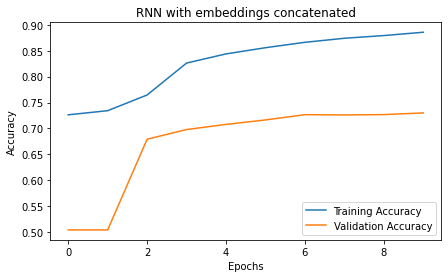

In [72]:
#Plotting the accuracy of the model made with RNN output states average with the embeddings concatenated
plot_accuracy(history_ave_conc, "RNN with embeddings concatenated", 'lower right')

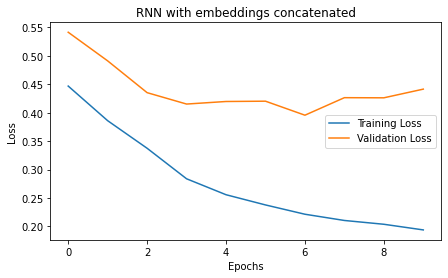

In [73]:
#Plotting the loss of the model made with RNN output states average with the embeddings concatenated
plot_loss(history_ave_conc, "RNN with embeddings concatenated", 'center right')

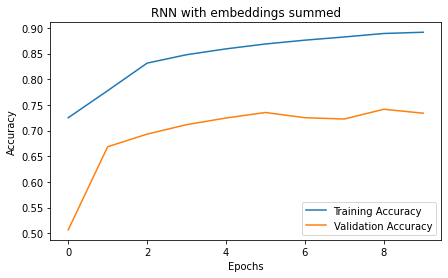

In [76]:
#Plotting the accuracy of the model made with RNN last output state with the summation of the embeddings
plot_accuracy(history_last_sum, "RNN with embeddings summed", 'lower right')

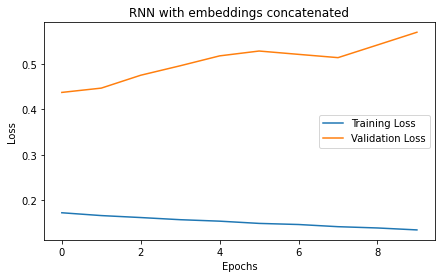

In [77]:
#Plotting the loss of the model made with RNN last output state with the summation of the embeddings
plot_loss(history_last_mean, "RNN with embeddings concatenated", 'center right')

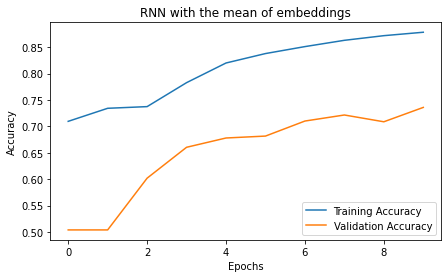

In [78]:
#Plotting the accuracy of the model made with RNN output states average with the mean of the embeddings
plot_accuracy(history_ave_mean, "RNN with the mean of embeddings", 'lower right')

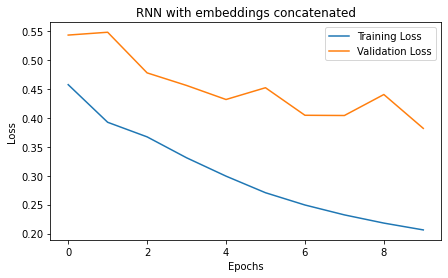

In [149]:
#Plotting the loss of the model made with RNN output states average with the mean of the embeddings
plot_loss(history_ave_mean, "RNN with embeddings concatenated", 'upper right')

## Models' Evaluation

In [80]:
def models_eval(model):
  loss, accuracy = model.evaluate(data_test, y_test, verbose=1)

In [81]:
#Best model with Concatenation because it has 73% of accuracy on validation set
models_eval(model_ave_conc)

225/225 [==============================] - 9s 38ms/step - loss: 0.4571 - acc: 0.7193


In [82]:
#Best model with summation because it has 72.77% of accuracy on validation set
models_eval(model_last_sum)

225/225 [==============================] - 9s 38ms/step - loss: 0.4763 - acc: 0.7194


In [83]:
#Best model with the mean because it has 72.99% of accuracy on validation set
models_eval(model_ave_mean)

225/225 [==============================] - 9s 38ms/step - loss: 0.4081 - acc: 0.7179


### Multi-input classification evaluation of the best models
 Precision Recall and F1 score

In [84]:
def prediction(model):
  predictions = model.predict(data_test)
  return predictions

In [85]:
def class_report(predictions,y_test_df):
  target_names = ['SUPPORT', 'REFUTES']                                                                                                                                                                             
  print(classification_report(y_test_df,predictions, target_names=target_names))

In [86]:
y_test_df = y_test.copy()
y_test_df = pd.DataFrame(y_test)
y_test_df = y_test_df.drop([0], axis=1)
def to_dataframe(pred):
  preds_df = pd.DataFrame((np.around(pred, decimals = 0, out = None)), dtype='int')
  preds_df = preds_df.drop([0], axis=1)
  return y_test_df,preds_df

Classifiction report of the best concatenation model

In [87]:
pred_conc = prediction(model_ave_conc)
y_test_df_conc, preds_df_conc = to_dataframe(pred_conc) 
class_report(preds_df_conc,y_test_df_conc)

              precision    recall  f1-score   support

     SUPPORT       0.67      0.87      0.76      3606
     REFUTES       0.81      0.57      0.67      3583

   micro avg       0.72      0.72      0.72      7189
   macro avg       0.74      0.72      0.71      7189
weighted avg       0.74      0.72      0.71      7189
 samples avg       0.72      0.72      0.72      7189



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation of the best summation model

In [110]:
pred_sum = prediction(model_last_sum)
y_test_df_sum, preds_df_sum = to_dataframe(pred_sum) 
class_report(preds_df_sum,y_test_df_sum)

              precision    recall  f1-score   support

     SUPPORT       0.67      0.89      0.76      3606
     REFUTES       0.83      0.55      0.66      3583

   micro avg       0.72      0.72      0.72      7189
   macro avg       0.75      0.72      0.71      7189
weighted avg       0.75      0.72      0.71      7189
 samples avg       0.72      0.72      0.72      7189



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation of the best mean model

In [120]:
pred_mean = prediction(model_ave_mean)
y_test_df_mean, preds_df_mean = to_dataframe(pred_mean) 
class_report(preds_df_mean,y_test_df_mean)

              precision    recall  f1-score   support

     SUPPORT       0.67      0.87      0.76      3606
     REFUTES       0.81      0.57      0.67      3583

   micro avg       0.72      0.72      0.72      7189
   macro avg       0.74      0.72      0.71      7189
weighted avg       0.74      0.72      0.71      7189
 samples avg       0.72      0.72      0.72      7189



### Confusion Matrix

In [90]:
def plot_cm(labels, predictions):
  labels_tot=['SUPPORTS', 'REFUTES']
  cm = confusion_matrix(labels, predictions)
  fig = plt.figure(figsize=(10,8))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt="d", ax=ax)
  ax.set_title('Confusion matrix')
  ax.set_ylabel('Actual label')
  ax.set_xlabel('Predicted label')
  ax.xaxis.set_ticklabels(labels_tot); 
  ax.yaxis.set_ticklabels(labels_tot);

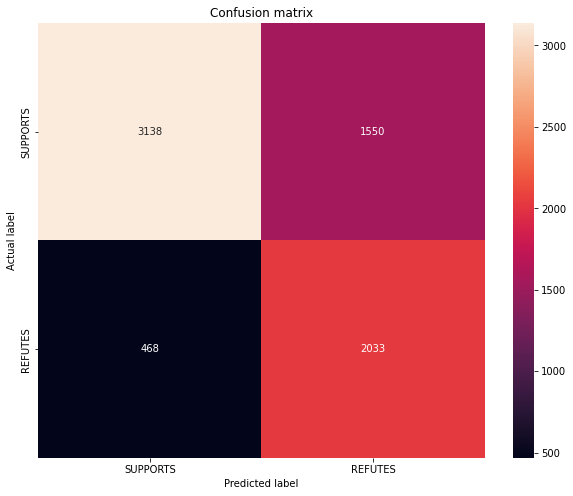

In [116]:
preds_df_conc = np.array(preds_df_conc)
y_test_df_conc = np.array(y_test_df_conc)
plot_cm(pred_conc.argmax(axis=1),y_test.argmax(axis=1))

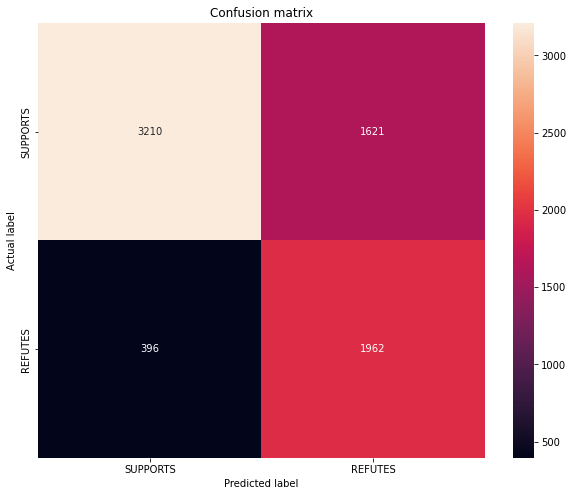

In [114]:
preds_df_sum = np.array(preds_df_sum)
y_test_df_sum = np.array(y_test_df_sum)

plot_cm(pred_sum.argmax(axis=1),y_test.argmax(axis=1))

In [108]:
len(preds_df_sum[i])
len(y_test_df_sum[i])

2

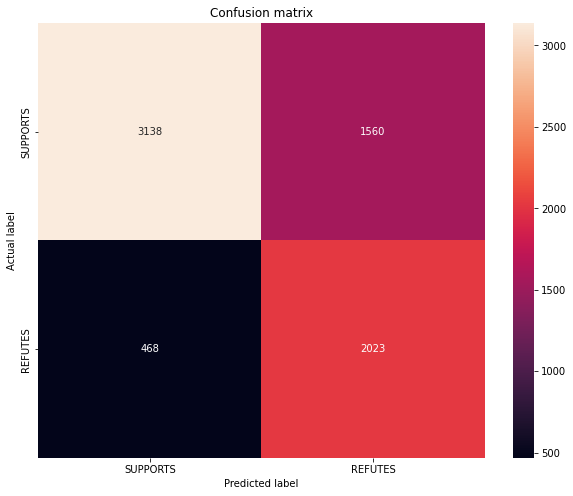

In [117]:
preds_df_mean = np.array(preds_df_mean)
y_test_df_mean = np.array(y_test_df_mean)
plot_cm(pred_mean.argmax(axis=1),y_test.argmax(axis=1))

## Claim verification evaluation
For a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs.

At this point, all we need to do is to compute the final predicted claim label via majority voting.

We can see that, the results are very similar to the previous once.

In [121]:
#We check for each claim which is the majority of votes for predicted labels and true labels
def counting_labels(preds,y_test):
  count_supp = 0
  count_ref = 0
  count_supp_true = 0
  count_ref_true = 0
  labels = []
  labels_true = []
  y_test_true = np.array(y_test.copy())
  y_test_pred = np.array(preds.copy())

  for i in range(0, len(data_test[0])-1):
    #if the two following claims are diffent it means that can evaluate the majority 
    #of the votes, so we add the last vote and we check which cotes are higher 
    #then we add it on the predicted labels
    #e.g clam1 != claim2 and claim1 has 2 supp and 1 ref then in the labels we append the support
    if list(data_test[0][i]) != list(data_test[0][i+1]):
      if list(y_test_pred[i]) == [0,1]:
        count_supp +=1
        if count_supp > count_ref:
          labels.append([0,1])
        else:
          labels.append([1,0])
        count_supp = 0
      else:
        count_ref += 1
        if count_supp > count_ref:
          labels.append([0,1])
        else:
          labels.append([1,0])
        count_ref = 0
      #we do the same for the true labels
      if list(y_test_true[i]) == [0,1]:
        count_supp_true +=1
        if count_supp_true > count_ref_true:
          labels_true.append([0,1])
        else:
          labels_true.append([1,0])
        count_supp_true = 0

      else:
        count_ref_true += 1
        if count_supp_true > count_ref_true:
          labels_true.append([0,1])
        else:
          labels_true.append([1,0])
        count_ref_true = 0
      
    #if the claims are equal we just add the votes
    else:
      if list(y_test_pred[i]) == [0,1]:
        count_supp +=1
      else:
        count_ref += 1
      
      #we do the same for the true labels
      if list(y_test_true[i]) == [0,1]:
        count_supp_true +=1
      else:
        count_ref_true += 1
  return labels, labels_true

We evaluate the best concatanation **model**

In [128]:
labels, labels_true = counting_labels(preds_df_conc,y_test_df_conc)

In [129]:
print(classification_report(labels_true, labels,target_names =["SUPPORTS","REFUTES"]))

              precision    recall  f1-score   support

    SUPPORTS       0.67      0.87      0.76      3308
     REFUTES       0.81      0.57      0.67      3297

   micro avg       0.72      0.72      0.72      6605
   macro avg       0.74      0.72      0.71      6605
weighted avg       0.74      0.72      0.71      6605
 samples avg       0.72      0.72      0.72      6605



We evaluate the best summation model

In [130]:
labels, labels_true = counting_labels(preds_df_sum,y_test_df_sum)

In [131]:
print(classification_report(labels_true,labels, target_names =["SUPPORTS","REFUTES"]))

              precision    recall  f1-score   support

    SUPPORTS       0.66      0.89      0.76      3308
     REFUTES       0.83      0.54      0.65      3297

   micro avg       0.72      0.72      0.72      6605
   macro avg       0.75      0.72      0.71      6605
weighted avg       0.75      0.72      0.71      6605
 samples avg       0.72      0.72      0.72      6605



We evaluate the best mean model

In [132]:
labels, labels_true = counting_labels(preds_df_mean,y_test_df_mean)

In [133]:
print(classification_report(labels_true, labels, target_names =["SUPPORTS","REFUTES"]))

              precision    recall  f1-score   support

    SUPPORTS       0.67      0.87      0.76      3308
     REFUTES       0.81      0.56      0.66      3297

   micro avg       0.72      0.72      0.72      6605
   macro avg       0.74      0.72      0.71      6605
weighted avg       0.74      0.72      0.71      6605
 samples avg       0.72      0.72      0.72      6605

